### Description:  This script produces Figure 14 (pseudo RHIs of reflectivity field overlaid with VHF sources in and near the plane of RHI with their polarity indicated). Creates a panel plot with subplots indicating different times of analysis

In [1]:
import glob
import math
import os
import warnings
from datetime import datetime, timedelta
from operator import itemgetter

import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import numpy as np

# import tables
import pandas as pd
import pyart
from matplotlib.dates import DateFormatter
from numpy import ones, vstack
from numpy.linalg import lstsq

from lmatools.coordinateSystems import (
    GeographicSystem,
    MapProjection,
    RadarCoordinateSystem,
)

import matplotlib.colors as colors
import xarray as xr

from may19_2013_obs_analysis.lma_parsing import point_to_line_dist
from may19_2013_obs_analysis.utils import sec2time
from may19_2013_obs_analysis.wsr88d_parsing import interval, plot_point
import  may19_2013_obs_analysis.cmap_ncarpid 

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams["axes.titlesize"] = 22


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Load KTLX radar files for May 19, 2013 case
source_dir_radar = os.path.expanduser("/path/to/KTLX/levelII/files/*")
files_radar = sorted(glob.glob(source_dir_radar + "/*V06", recursive=True))

# Load cfradial files generated from RadXPid containing Hydrometeor classification data
pid_files = sorted(
    glob.glob("/path/to/HID_output/cfradial/files/*.nc")
)

In [3]:
# We are interested in KTLX level II data available in the volume scan beginning at 211920 UTC

files_rad_interest = list(
    itemgetter(15, 16, 17, 18, 20, 21, 22, 23, 24, 25)(files_radar)
)

files_pid_interest = list(
    itemgetter(15, 16, 17, 18, 20, 21, 22, 23, 24, 25)(pid_files)
)


files_rad_interest = [files_rad_interest[3]]
files_pid_interest = [files_pid_interest[3]]


# Load charge classification file to plot individual classified
# VHF source on top of pseudoRHIs from radar

# Load charge classification file 2110_2120 UTC
file_charge2 = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2110_2120.txt"
)

data_charge2 = pd.read_csv(
    file_charge2,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge2 = data_charge2.drop(columns="mask")

# Load charge classification file 2120_2123 UTC
file_charge = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2120_2123.txt"
)

data_charge = pd.read_csv(
    file_charge,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge = data_charge.drop(columns="mask")

# Load charge classification file 2130_2140 UTC
file_charge3 = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2130_2140.txt"
)

data_charge3 = pd.read_csv(
    file_charge3,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge3 = data_charge3.drop(columns="mask")

# Load charge classification file 2140_2150 UTC
file_charge4 = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2140_2150.txt"
)

data_charge4 = pd.read_csv(
    file_charge4,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge4 = data_charge4.drop(columns="mask")

# merge all four charge classification files to produce a single DataFrame
merged_data_charge = data_charge.append(
    [data_charge2, data_charge3, data_charge4], sort=False
)

In [ ]:
threshold = 0.25  # This threshold means all VHF sources within 500 m on either side of azimuth will be considered for overlay

for f in files_rad_interest:
    radar = pyart.io.read(f)
    display = pyart.graph.RadarMapDisplay(radar)

    az_range = [323, 338, 349]

    for azimuth in az_range:

        fig = plt.figure(figsize=(12, 12))

        endx, endy = plot_point((0, 0), azimuth, 60)

        display.plot_ppi_map(
            "reflectivity",
            vmin=0,
            vmax=70,
            min_lon=-98,
            max_lon=-96.5,
            min_lat=35,
            max_lat=36.1,
            title_flag=False,
            colorbar_flag=False,
            lat_lines=[0],
            lon_lines=[0]
        )
        display.plot_line_xy([0, endx], [0, endy],color='k',linewidth=2)
        plt.show()

        data, x, y, z = display._get_azimuth_rhi_data_x_y_z(
            "reflectivity",
            azimuth,
            edges=True,
            mask_tuple=None,
            filter_transitions=True,
            gatefilter=None,
        )
        R = np.sqrt(x ** 2 + y ** 2)

        x_1d = x.flatten()
        y_1d = y.flatten()
        z_1d = z.flatten()

        # Calculations to find the distance between
        # a given point and a given line in 2 D.

        # Since there is a slight difference between the x,y coordinates of last point on 1st scan and last point
        points = [(x[0, :][0], y[0, :][0]), (x[-1, :][-1], y[0, :][-1])]
        # on the highest scan, that's why went this this approach.
        x_coords, y_coords = zip(*points)
        A = vstack([x_coords, ones(len(x_coords))]).T
        m, c1 = lstsq(A, y_coords)[0]

        out = interval(radar)
        interval_left1, interval_left2, interval_right1, interval_right2 = out
        charge_pt_mask = (merged_data_charge["time"] > interval_left1) & (
            merged_data_charge["time"] < interval_right2
        )  # filtering only those flashes which occurred during radar scan
        filtered_charge = merged_data_charge[charge_pt_mask]

        # filter to further positively charged sources after time filter above
        pos_mask = filtered_charge["charge"] == 3
        pos_charge = filtered_charge[pos_mask]
        pos_charge_lat = pos_charge["lat"]
        pos_charge_lon = pos_charge["lon"]
        pos_charge_alt = pos_charge["alt"]
        pos_charge_alt = np.asarray(pos_charge_alt)
        pos_x, pos_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            pos_charge_lon,
            pos_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # filter to further negatively charged sources after time filter above
        neg_mask = filtered_charge["charge"] == -3
        neg_charge = filtered_charge[neg_mask]
        neg_charge_lat = neg_charge["lat"]
        neg_charge_lon = neg_charge["lon"]
        neg_charge_alt = neg_charge["alt"]
        neg_charge_alt = np.asarray(neg_charge_alt)
        neg_x, neg_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            neg_charge_lon,
            neg_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # next step is to include only those flashes which occurred with 1-2 km of the x-section

        li_pos = []
        for i in range(len(pos_x)):
            point = [pos_x[i] / 1000.0, pos_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_pos.append(disti)

        li_neg = []
        for i in range(len(neg_x)):
            point = [neg_x[i] / 1000.0, neg_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_neg.append(disti)

        idx_pos = np.where(np.asarray(li_pos) <= threshold)
        idx_neg = np.where(np.asarray(li_neg) <= threshold)

        R_pos = np.sqrt((pos_x[idx_pos] / 1000.0) ** 2 + (pos_y[idx_pos] / 1000.0) ** 2)
        R_neg = np.sqrt((neg_x[idx_neg] / 1000.0) ** 2 + (neg_y[idx_neg] / 1000.0) ** 2)

        fig = plt.figure(figsize=(14, 6))
        zh = plt.pcolormesh(R, z, data, vmin=0, vmax=70, cmap="pyart_HomeyerRainbow")
        
        plt.axhline(y=4.436,linestyle='dotted',linewidth=4,c='r',label='0$^{\circ}$C')
        plt.axhline(y=5.376,linestyle='dashed',linewidth=3,c='b',label='-10$^{\circ}$C')
        plt.axhline(y=9.490,linestyle='dashdot',linewidth=3,c='k',label='-40$^{\circ}$C')
    
        plt.scatter(
            R_pos,
            pos_charge_alt[idx_pos] / 1000.0,
            c="r",
            marker="s",
            label="pos",
            edgecolors="k",
        )
        plt.scatter(
            R_neg,
            neg_charge_alt[idx_neg] / 1000.0,
            c="b",
            marker="s",
            label="neg",
            edgecolors="k",
        )

        plt.xlabel("Range from radar (in km)")
        plt.ylabel("Altitude above MSL (in km)")
#         for j in [2, 4, 6, 8, 10]:
#             plt.axhline(y=j, color="gray", linestyle="--")
#         for k in [30, 40, 50, 60]:
#             plt.axvline(x=k, color="gray", linestyle="--")

        # plt.axhline(y = 8 ,color='k',linestyle='--')
        plt.title(
            "VHF sources between %s and %s UTC, Azimuth %s$^\circ$"
            % (sec2time(interval_left1)[0:8], sec2time(interval_right2)[0:8], azimuth)
        )
        plt.xlim(0, 70)
        plt.ylim(0, 17)
#         plt.legend(loc="best",fontsize='medium')
#         plt.colorbar(mappable=zh, label="Reflectivity (dBZ)")

        plt.show()

In [ ]:
legend = fig.legend(loc='bottom right')

In [ ]:
def export_legend(legend, filename="legend.png", expand=[-12,-13,2,2]):
    fig1  = legend.figure
    fig1.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig1.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [ ]:
threshold = 0.25  # This threshold means all VHF sources within 500 m on either side of azimuth will be considered for overlay

for f in files_rad_interest:
    radar = pyart.io.read(f)
    display = pyart.graph.RadarMapDisplay(radar)

    az_range = [323, 338, 349]
    for azimuth in az_range:

#         fig = plt.figure(figsize=(12, 12))

        data, x, y, z = display._get_azimuth_rhi_data_x_y_z(
            "differential_reflectivity",
            azimuth,
            edges=True,
            mask_tuple=None,
            filter_transitions=True,
            gatefilter=None,
        )
        R = np.sqrt(x ** 2 + y ** 2)

        x_1d = x.flatten()
        y_1d = y.flatten()
        z_1d = z.flatten()

        # Calculations to find the distance between
        # a given point and a given line in 2 D.

        # Since there is a slight difference between the x,y coordinates of last point on 1st scan and last point
        points = [(x[0, :][0], y[0, :][0]), (x[-1, :][-1], y[0, :][-1])]
        # on the highest scan, that's why went this this approach.
        x_coords, y_coords = zip(*points)
        A = vstack([x_coords, ones(len(x_coords))]).T
        m, c1 = lstsq(A, y_coords)[0]

        out = interval(radar)
        interval_left1, interval_left2, interval_right1, interval_right2 = out
        charge_pt_mask = (merged_data_charge["time"] > interval_left1) & (
            merged_data_charge["time"] < interval_right2
        )  # filtering only those flashes which occurred during radar scan
        filtered_charge = merged_data_charge[charge_pt_mask]

        # filter to further positively charged sources after time filter above
        pos_mask = filtered_charge["charge"] == 3
        pos_charge = filtered_charge[pos_mask]
        pos_charge_lat = pos_charge["lat"]
        pos_charge_lon = pos_charge["lon"]
        pos_charge_alt = pos_charge["alt"]
        pos_charge_alt = np.asarray(pos_charge_alt)
        pos_x, pos_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            pos_charge_lon,
            pos_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # filter to further negatively charged sources after time filter above
        neg_mask = filtered_charge["charge"] == -3
        neg_charge = filtered_charge[neg_mask]
        neg_charge_lat = neg_charge["lat"]
        neg_charge_lon = neg_charge["lon"]
        neg_charge_alt = neg_charge["alt"]
        neg_charge_alt = np.asarray(neg_charge_alt)
        neg_x, neg_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            neg_charge_lon,
            neg_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # next step is to include only those flashes which occurred with 1-2 km of the x-section

        li_pos = []
        for i in range(len(pos_x)):
            point = [pos_x[i] / 1000.0, pos_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_pos.append(disti)

        li_neg = []
        for i in range(len(neg_x)):
            point = [neg_x[i] / 1000.0, neg_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_neg.append(disti)

        idx_pos = np.where(np.asarray(li_pos) <= threshold)
        idx_neg = np.where(np.asarray(li_neg) <= threshold)

        R_pos = np.sqrt((pos_x[idx_pos] / 1000.0) ** 2 + (pos_y[idx_pos] / 1000.0) ** 2)
        R_neg = np.sqrt((neg_x[idx_neg] / 1000.0) ** 2 + (neg_y[idx_neg] / 1000.0) ** 2)

        fig = plt.figure(figsize=(14, 6))
        zdr = plt.pcolormesh(R, z, data, vmin=0, vmax=7, cmap="pyart_HomeyerRainbow")

        plt.scatter(
            R_pos,
            pos_charge_alt[idx_pos] / 1000.0,
            c="r",
            marker="s",
            label="pos",
            edgecolors="k",
        )
        plt.scatter(
            R_neg,
            neg_charge_alt[idx_neg] / 1000.0,
            c="b",
            marker="s",
            label="neg",
            edgecolors="k",
        )
        
        plt.axhline(y=4.436,linestyle='dotted',linewidth=4,c='r',label='0$^{\circ}$C')
        plt.axhline(y=5.376,linestyle='dashed',linewidth=3,c='b',label='-10$^{\circ}$C')
        plt.axhline(y=9.490,linestyle='dashdot',linewidth=3,c='k',label='-40$^{\circ}$C')
        
        plt.xlabel("Range from radar (in km)")
        plt.ylabel("Altitude above MSL (in km)")
#         for j in [2, 4, 6, 8, 10]:
#             plt.axhline(y=j, color="gray", linestyle="--")
#         for k in [30, 40, 50, 60]:
#             plt.axvline(x=k, color="gray", linestyle="--")

        # plt.axhline(y = 8 ,color='k',linestyle='--')
        plt.title(
            "VHF sources between %s and %s UTC, Azimuth %s$^\circ$"
            % (sec2time(interval_left1)[0:8], sec2time(interval_right2)[0:8], azimuth)
        )
        plt.xlim(0, 70)
        plt.ylim(0, 17)
#         plt.legend(loc="best")
        plt.colorbar(mappable=zdr, label="Differential reflectivity (dB)")

        plt.show()

In [5]:
# Although we have a module for cmapncarpid available but
# that won't work with hvplot (at least yet) as it is not 
# one of the default colormaps in matplotlib,bokeh etc.

# So, let's still define our ncarpid map here

import matplotlib as mpl
import matplotlib.colors as colors


def hex_to_rgb(value):
    """
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values"""
    value = value.strip("#")  # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i : i + lv // 3], 16) for i in range(0, lv, lv // 3))


hid_colors = [
    "#D7CCC8",
    "FFCCBC",
    "FF8A65",
    "BF360C",
    "F44336",
    "FFEE58",
    "94D82D",
    "51CF66",
    "2B8A3E",
    "66D9E8",
    "228BE6",
    "364FC7",
    "EEBEFA",
    "F783AC",
    "F8F9FA",
    "F8F9FA",
    "F8F9FA",
    "F8F9FA",
]


cmaphid_colors = [hex_to_rgb(color) for color in hid_colors]
cmaphid = [[t / 255 for t in x] for x in cmaphid_colors]

cmapncarpid = colors.ListedColormap(cmaphid)
plt.register_cmap(name="ncarpid", cmap=cmapncarpid)

In [6]:
# As per NCAR PID algorithm, RadxPid generates 18 hydrometeor categories

# (1) -> Cloud (CL), (2) -> Drizzle (DRZ), (3) -> Light_Rain (LR), (4) -> Moderate_Rain (MR),
# (5) -> Heavy_Rain (HR), (6) -> Hail (HA), (7) -> Rain_Hail_Mixture (RH), (8) -> Graupel_Small_Hail (GSH),
# (9) -> Graupel_Rain (GRR), (10) -> Dry_Snow (DS), (11) -> Wet_Snow (WS), (12) -> Ice_Crystals (IC),
# (13) -> Irreg_Ice_Crystals (IIC), (14) -> Supercooled_Liquid_Droplets (SLD)

from bokeh.models.tickers import FixedTicker

ticker = FixedTicker(desired_num_ticks=18)

ticker.ticks = np.arange(1.5, 17.5, 0.94)
hid_class = [
    "CL",
    "DRZ",
    "LR",
    "MR",
    "HR",
    "HA",
    "RH",
    "GSH",
    "GRR",
    "DS",
    "WS",
    "IC",
    "IIC",
    "SLD",
    "BGS",
    "TRIP2",
    "GCL",
    "SAT",
]

clabs = dict(zip(ticker.ticks, hid_class))
ccols = dict(zip(hid_class,cmapncarpid.colors))

<Figure size 864x864 with 0 Axes>

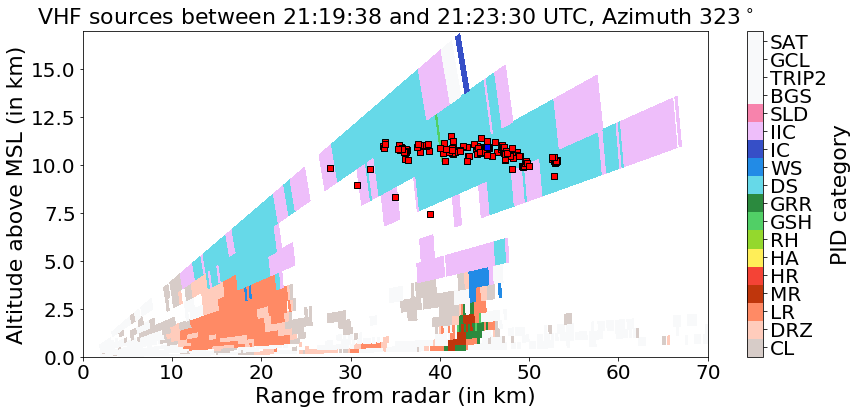

<Figure size 864x864 with 0 Axes>

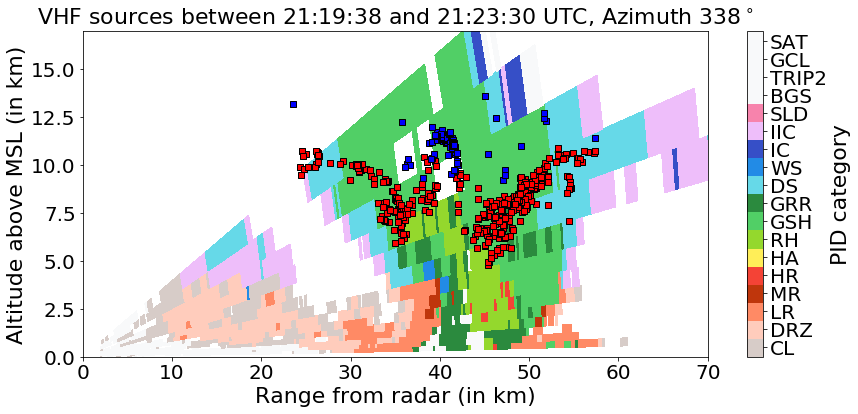

<Figure size 864x864 with 0 Axes>

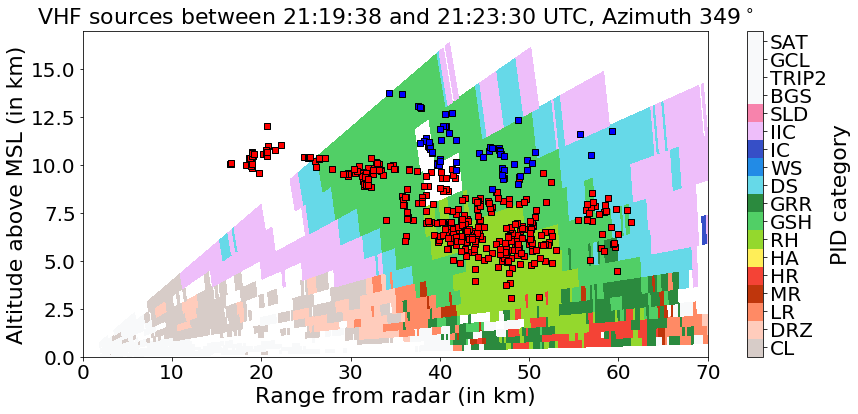

In [7]:
plt.rcParams["ytick.labelsize"] = 20

threshold = 0.25  # This threshold means all VHF sources within 500 m on either side of azimuth will be considered for overlay

for f in files_pid_interest:
    radar = pyart.io.read(f)
    display = pyart.graph.RadarMapDisplay(radar)

    az_range = [323, 338, 349]
    for azimuth in az_range:

        fig = plt.figure(figsize=(12, 12))

        data, x, y, z = display._get_azimuth_rhi_data_x_y_z(
            "PID",
            azimuth,
            edges=True,
            mask_tuple=None,
            filter_transitions=True,
            gatefilter=None,
        )
        
        data_new = xr.DataArray(data)
        data_new = data_new.where(data_new >=1)

        R = np.sqrt(x ** 2 + y ** 2)

        x_1d = x.flatten()
        y_1d = y.flatten()
        z_1d = z.flatten()

        # Calculations to find the distance between
        # a given point and a given line in 2 D.

        # Since there is a slight difference between the x,y coordinates of last point on 1st scan and last point
        points = [(x[0, :][0], y[0, :][0]), (x[-1, :][-1], y[0, :][-1])]
        # on the highest scan, that's why went this this approach.
        x_coords, y_coords = zip(*points)
        A = vstack([x_coords, ones(len(x_coords))]).T
        m, c1 = lstsq(A, y_coords)[0]

        out = interval(radar)
        interval_left1, interval_left2, interval_right1, interval_right2 = out
        charge_pt_mask = (merged_data_charge["time"] > interval_left1) & (
            merged_data_charge["time"] < interval_right2
        )  # filtering only those flashes which occurred during radar scan
        filtered_charge = merged_data_charge[charge_pt_mask]

        # filter to further positively charged sources after time filter above
        pos_mask = filtered_charge["charge"] == 3
        pos_charge = filtered_charge[pos_mask]
        pos_charge_lat = pos_charge["lat"]
        pos_charge_lon = pos_charge["lon"]
        pos_charge_alt = pos_charge["alt"]
        pos_charge_alt = np.asarray(pos_charge_alt)
        pos_x, pos_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            pos_charge_lon,
            pos_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # filter to further negatively charged sources after time filter above
        neg_mask = filtered_charge["charge"] == -3
        neg_charge = filtered_charge[neg_mask]
        neg_charge_lat = neg_charge["lat"]
        neg_charge_lon = neg_charge["lon"]
        neg_charge_alt = neg_charge["alt"]
        neg_charge_alt = np.asarray(neg_charge_alt)
        neg_x, neg_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            neg_charge_lon,
            neg_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # next step is to include only those flashes which occurred with 1-2 km of the x-section

        li_pos = []
        for i in range(len(pos_x)):
            point = [pos_x[i] / 1000.0, pos_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_pos.append(disti)

        li_neg = []
        for i in range(len(neg_x)):
            point = [neg_x[i] / 1000.0, neg_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_neg.append(disti)

        idx_pos = np.where(np.asarray(li_pos) <= threshold)
        idx_neg = np.where(np.asarray(li_neg) <= threshold)

        R_pos = np.sqrt((pos_x[idx_pos] / 1000.0) ** 2 + (pos_y[idx_pos] / 1000.0) ** 2)
        R_neg = np.sqrt((neg_x[idx_neg] / 1000.0) ** 2 + (neg_y[idx_neg] / 1000.0) ** 2)

        fig = plt.figure(figsize=(14, 6))
        pid = plt.pcolormesh(R, z, data_new, vmin=1, vmax=18, cmap='ncarpid')

        plt.scatter(
            R_pos,
            pos_charge_alt[idx_pos] / 1000.0,
            c="r",
            marker="s",
            label="pos",
            edgecolors="k",
        )
        plt.scatter(
            R_neg,
            neg_charge_alt[idx_neg] / 1000.0,
            c="b",
            marker="s",
            label="neg",
            edgecolors="k",
        )

        plt.xlabel("Range from radar (in km)")
        plt.ylabel("Altitude above MSL (in km)")
#         for j in [2, 4, 6, 8, 10]:
#             plt.axhline(y=j, color="gray", linestyle="--")
#         for k in [30, 40, 50, 60]:
#             plt.axvline(x=k, color="gray", linestyle="--")

        # plt.axhline(y = 8 ,color='k',linestyle='--')
        plt.title(
            "VHF sources between %s and %s UTC, Azimuth %s$^\circ$"
            % (sec2time(interval_left1)[0:8], sec2time(interval_right2)[0:8], azimuth)
        )
        plt.xlim(0, 70)
        plt.ylim(0, 17)
#         plt.legend(loc="upper left",markerscale=2)
        cbar = plt.colorbar(mappable=pid, label="PID category")
        
        cbar.set_ticks(ticker.ticks)
        cbar.ax.set_yticklabels(hid_class)
        plt.show()